In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import torch.utils.data as data
import torchvision.models as models
import torchvision.utils as v_utils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
# 필요한 이미지들을 다운받습니다.

!rm -r images
import os 

try:
  os.mkdir("images")
  os.mkdir("images/content")
  os.mkdir("images/style")
except:
  pass

!wget https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg -P images/content
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg -P images/style

rm: cannot remove 'images': No such file or directory
--2019-11-08 03:01:45--  https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 406531 (397K) [image/jpeg]
Saving to: ‘images/content/Tuebingen_Neckarfront.jpg’

Tuebingen_Neckarfro 100%[===================>] 397.00K  --.-KB/s    in 0.03s   

2019-11-08 03:01:45 (15.3 MB/s) - ‘images/content/Tuebingen_Neckarfront.jpg’ saved [406531/406531]

--2019-11-08 03:01:47--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
resnet = models.resnet50(pretrained=True)
# 사전에 학습된 ResNet-50을 불러온다. 
# 컨텐츠 손실을 어느 지점에서 맞출것인지 지정해놓습니다.
content_layer_num = 1
image_size = 512
epoch = 5000
content_dir = "/content/images/content/test.jpg"
style_dir = "./images/style/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

In [0]:
for name,module in resnet.named_children():
  print(name)

# resnet 모델의 직속 자식노드들을 불러온다
# conv1
# bn1
# relu
# maxpool
# layer1
# layer2
# layer3
# layer4
# avgpool
# fc
# 결과를 보면 레이어4 까지는 이미지 데이터에서 특성을 추출하고 이를 avgpool에서 
# 평균을 내고 fc를 통과시켜 분류를 완료한다.

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [0]:
# class Resnet(nn.Module):
#   def __init__(self):
#     super(Resnet,self).__init__()
#     self.layer0 = nn.Sequential(*list(resnet.children())[0:-1])
#     # resnet.children()을 부르되 이름은 빼고(resnet.named_children() 이게 아님!) 
#     # 모듈만 불러온다. 모듈안에는 학습된 변수들이 포함되어 있다. 
#     # 리턴되는 값이 제너레이터이기 때문에 리스트로 바꿔주고, 
#     # fc층은 사용하지 않을거기 때문에 [0:-1] 인덱싱함
#     # 또한 리스트가 아닌 리스트의 내용을 전달해야하기 때문에 * 를 붙여서 언패킹 해야함.
#     self.layer1 = nn.Sequential(
#         nn.Linear(2048,500),
#         nn.BatchNorm1d(500),
#         nn.ReLU(),
#         nn.Linear(500,num_category),
#         nn.ReLU()
#     )
#   def forward(self,x):
#     out = self.layer0(x)
#     # 4차원의 텐서를 nn.Linear 함수에 맞게 2차원으로 바꿔준다.
#     out = out.view(batch_size,-1)
#     out = self.layer1(out)
#     return out

In [0]:
# 이미 학습된 ResNet 모델이 이미지넷으로 학습된 모델이기 때문에 이에 따라 정규화해줍니다.

def image_preprocess(img_dir):
    img = Image.open(img_dir)
    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.CenterCrop(image_size),
                    
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], 
                                         std=[1,1,1]),
                ])
    img = transform(img).view((-1,3,image_size,image_size))
    return img
# 이미지 파일을 읽어와서 이미지넷 데이터 분포에 따라 정규화하는 함수다.
# 정규화 된 상태로 연산을 진행하고 다시 이미지화 해서 보기위해 뺐던 값들을 다시 더해줍니다.
# 또한 이미지가 0에서 1사이의 값을 가지게 해줍니다.

def image_postprocess(tensor):
    transform = transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], 
                                     std=[1,1,1])
    img = transform(tensor.clone())
    img = img.clamp(0,1)
    img = torch.transpose(img,0,1)
    img = torch.transpose(img,1,2)
    return img

In [0]:
# 레이어마다 결과값을 가져올 수 있게 forward를 정의합니다.

class Resnet(nn.Module):
    def __init__(self):
        super(Resnet,self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:1])
        # 특성 맵을 뽑고싶은 위치를 정해서 그 위치를 단위로 레이어들을 만들어준다.
        self.layer1 = nn.Sequential(*list(resnet.children())[1:4])
        self.layer2 = nn.Sequential(*list(resnet.children())[4:5])
        self.layer3 = nn.Sequential(*list(resnet.children())[5:6])
        self.layer4 = nn.Sequential(*list(resnet.children())[6:7])
        self.layer5 = nn.Sequential(*list(resnet.children())[7:8])

    def forward(self,x):
        out_0 = self.layer0(x)
        out_1 = self.layer1(out_0)
        out_2 = self.layer2(out_1)
        out_3 = self.layer3(out_2)
        out_4 = self.layer4(out_3)
        out_5 = self.layer5(out_4)
        return out_0, out_1, out_2, out_3, out_4, out_5

# for param in resnet.parameters():
#   param.requires_grad = False

In [0]:
# 그람 행렬을 생성하는 클래스 및 함수를 정의합니다. 
# [batch,channel,height,width] -> [b,c,h*w]
# [b,c,h*w] x [b,h*w,c] = [b,c,c]
# 그람행렬을 만들기 위해서는 이를 벡터화해야 한다.
# 일렬로 쭉 펴면 벡터가 된다.

# 활성화 지도를 그람 행렬화 하는 코드와 이를 이용해 손실을 계산하는 코드.
# torch.bmm은 [batch_size,l,m] 형태의 텐서와 [batch_size,m,n]형태의 텐서에 대해
# 배치 크기 부분은 연산에서 제외하고 [l,m] 과 [m,n] 부분에 대해서만 행렬곱 연산을 수행하는 함수다

class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 

        return G

class GramMSELoss(nn.Module):
  def forward(self,input,target):
    out = nn.MSELoss()(GramMatrix()(input),target)
    # 손실계산
    return out

In [0]:
# 모델을 학습의 대상이 아니기 때문에 requires_grad를 False로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

resnet = Resnet().to(device)
for param in resnet.parameters():
    param.requires_grad = False

cuda:0


In [0]:
# # 그람행렬간의 손실을 계산하는 클래스 및 함수를 정의합니다.

# class GramMSELoss(nn.Module):
#     def forward(self, input, target):
#         out = nn.MSELoss()(GramMatrix()(input), target)
#         return out

False False True


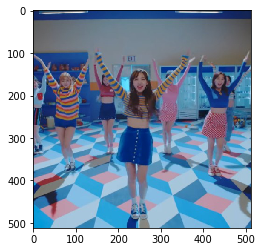

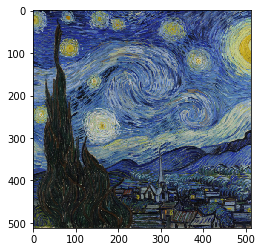

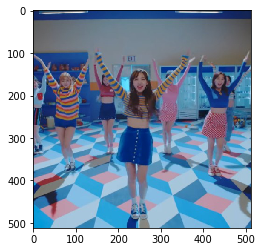

In [0]:
# 컨텐츠 이미지, 스타일 이미지, 학습의 대상이 되는 이미지를 정의합니다.
# 스타일과 콘텐츠 이미지는 학습의 대상이 아니므로 학습대상에서 빼준다.

content = image_preprocess(content_dir).to(device)
style = image_preprocess(style_dir).to(device)
generated = content.clone().requires_grad_().to(device)
# 발생기만 기울기 학습 시킴
print(content.requires_grad,style.requires_grad,generated.requires_grad)

# 각각을 시각화 합니다.

# Content
plt.imshow(image_postprocess(content[0].cpu()))
plt.show()

# Style
plt.imshow(image_postprocess(style[0].cpu()))
plt.show()

# generator
gen_img = image_postprocess(generated[0].cpu()).data.numpy()
plt.imshow(gen_img)
plt.show()

# 새 섹션

In [0]:
# 목표값을 설정하고 행렬의 크기에 따른 가중치도 함께 정의해놓습니다

style_target = list(GramMatrix().to(device)(i) for i in resnet(style))
# 학습동안 변함없는 스타일 목표값과 콘텐츠 목표값을 정한다
content_target = resnet(content)[content_layer_num]
style_weight = [1/n**2 for n in [64,64,256,512,1024,2048]]

In [0]:
# LBFGS 최적화 함수를 사용합니다.
# 이때 학습의 대상은 모델의 가중치가 아닌 이미지 자체입니다.
# for more info about LBFGS -> http://pytorch.org/docs/optim.html?highlight=lbfgs#torch.optim.LBFGS

optimizer = optim.LBFGS([generated])
# 기존 기울기들을 기억해 2차 미분값을 계산하기 때문에 클로저를 작성해 1자 미분값들을 전달해줘야 한다.

iteration = [0]
while iteration[0] < epoch:
    def closure():
        optimizer.zero_grad()
        out = resnet(generated)
        
        # 스타일 손실을 각각의 목표값에 따라 계산하고 이를 리스트로 저장합니다.
        style_loss = [GramMSELoss().to(device)(out[i],style_target[i])*style_weight[i] for i in range(len(style_target))]
        
        # 컨텐츠 손실은 지정한 위치에서만 계산되므로 하나의 수치로 저장됩니다.
        content_loss = nn.MSELoss().to(device)(out[content_layer_num],content_target)
        
        # 스타일:컨텐츠 = 1000:1의 비중으로 총 손실을 계산합니다.
        total_loss = 1000 * sum(style_loss) + torch.sum(content_loss)
        total_loss.backward()

        if iteration[0] % 100 == 0:
            print(total_loss)
        iteration[0] += 1
        return total_loss

    optimizer.step(closure)

tensor(2732616.5000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(71.3381, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.6788, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.0815, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1033, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3347, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9629, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7386, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5924, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4927, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4227, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3712, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3311, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2993, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2738, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2523, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2352, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2208, device='cuda:0', grad_fn=

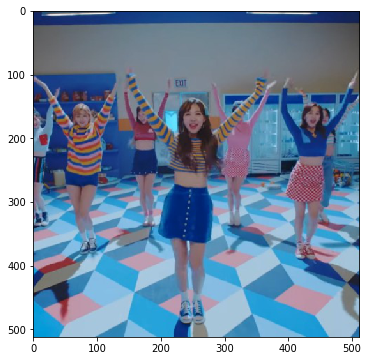

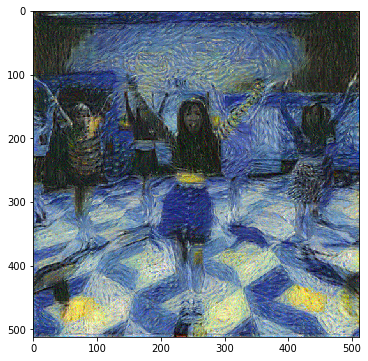

In [0]:
# 학습된 결과 이미지를 확인합니다.
plt.figure(figsize=(6,6))
plt.imshow(image_postprocess(content[0].cpu()))
plt.show()

gen_img = image_postprocess(generated[0].cpu()).data.numpy()

plt.figure(figsize=(6,6))
plt.imshow(gen_img)
plt.show()